In [ ]:
## max_prediction length = 20, date_range('2016-01-4', '2020-03-31')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install pytorch-lightning  

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install pytorch-forecasting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import warnings
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import optuna

from typing import Any, Callable, Dict, List, Optional, Tuple, Union
from sklearn.preprocessing import MinMaxScaler


import torch
import torch.nn.functional as F
from torch import distributions

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting.data.examples import generate_ar_data

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet, QuantileLoss
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.metrics import SMAPE, DistributionLoss, NormalDistributionLoss, LogNormalDistributionLoss, BaseEstimator
from pytorch_forecasting.data.encoders import GroupNormalizer
import tensorflow as tf 
import tensorboard as tb 
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
data = pd.read_excel('/content/drive/MyDrive/교육/AI실무인증과정/학회 발표/data/data_full.xlsx')
data.head()

Date Account DOW  REV OBD  OBD NET+FSC_KRW  OBD A/R_KRW  REV CPN  \
0 2016-01-01         FRI  25196.0     9.923237e+09  393841.7444   5517.0   
1 2016-01-02         SAT  27495.0     1.106671e+10  402499.1654   6320.0   
2 2016-01-03         SUN  31843.0     1.270800e+10  399083.0044   4292.0   
3 2016-01-04         MON  28000.0     1.154173e+10  412204.5697  36263.0   
4 2016-01-05         TUE  24657.0     1.008791e+10  409129.4946  38432.0   

   CPN NET+FSC_KRW  CPN A/R_KRW  REV TKT  TKT NET+FSC_KRW  TKT A/R_KRW    WTI  \
0     2.410238e+09  436874.6714   3188.0     2.236210e+09  701446.0183   0.00   
1     2.500112e+09  395587.3387   3577.0     2.405358e+09  672451.2796   0.00   
2     1.813688e+09  422573.9862   2521.0     1.697046e+09  673163.7338   0.00   
3     1.465623e+10  404164.9715  19528.0     1.454451e+10  744803.0601  36.76   
4     1.538667e+10  400360.8701  20461.0     1.555175e+10  760067.7182  35.97   

   exchanges    kospi  rates  stock_a  stock_k  stock_kkj  
0        0.0     0.00   0.00      0.0      0.0        0.0  
1        0.0     0.00   0.00      0.0      0.0        0.0  
2        0.0     0.00   0.00      0.0      0.0        0.0  
3     1189.5  1918.76   1.63  21429.0  16459.0   108918.0  
4     1189.5  1930.53   1.64  20881.0  16186.0   108918.0

In [ ]:
data.tail()

Date Account DOW  REV OBD  OBD NET+FSC_KRW   OBD A/R_KRW  REV CPN  \
1853 2021-01-27         WED   1099.0      872488809.0  7.938934e+05    557.0   
1854 2021-01-28         THU    369.0      346194072.0  9.381953e+05    686.0   
1855 2021-01-29         FRI    929.0      697137374.0  7.504170e+05    682.0   
1856 2021-01-30         SAT    504.0      394144488.0  7.820327e+05    261.0   
1857 2021-01-31         SUN    461.0      463553317.0  1.005539e+06    302.0   

      CPN NET+FSC_KRW   CPN A/R_KRW  REV TKT  TKT NET+FSC_KRW   TKT A/R_KRW  \
1853     4.829877e+08  8.671234e+05    446.0     5.687120e+08  1.275139e+06   
1854     5.998695e+08  8.744453e+05    533.0     6.906058e+08  1.295696e+06   
1855     6.035898e+08  8.850290e+05    540.0     6.792015e+08  1.257780e+06   
1856     2.191663e+08  8.397174e+05    186.0     2.128566e+08  1.144391e+06   
1857     3.645140e+08  1.207000e+06    215.0    -1.330932e+08 -6.190380e+05   

        WTI  exchanges    kospi  rates  stock_a  stock_k  stock_kkj  
1853  52.85     1105.0  3122.56   0.98  17302.0  30400.0    59587.0  
1854  52.34     1118.0  3069.05   0.97  17023.0  29650.0    58220.0  
1855  52.20     1117.5  2976.21   0.97  16353.0  28700.0    56657.0  
1856  52.20     1117.5  2976.21   0.97  16353.0  28700.0    56657.0  
1857  52.20     1117.5  2976.21   0.97  16353.0  28700.0    56657.0

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1858 entries, 0 to 1857
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             1858 non-null   datetime64[ns]
 1   Account DOW      1858 non-null   object        
 2   REV OBD          1858 non-null   float64       
 3   OBD NET+FSC_KRW  1858 non-null   float64       
 4   OBD A/R_KRW      1858 non-null   float64       
 5   REV CPN          1858 non-null   float64       
 6   CPN NET+FSC_KRW  1858 non-null   float64       
 7   CPN A/R_KRW      1858 non-null   float64       
 8   REV TKT          1858 non-null   float64       
 9   TKT NET+FSC_KRW  1858 non-null   float64       
 10  TKT A/R_KRW      1858 non-null   float64       
 11  WTI              1858 non-null   float64       
 12  exchanges        1858 non-null   float64       
 13  kospi            1858 non-null   float64       
 14  rates            1858 non-null   float64

In [ ]:
res_data = data[data["Date"].isin(pd.date_range('2016-01-4', '2020-03-31'))]
res_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1549 entries, 3 to 1551
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             1549 non-null   datetime64[ns]
 1   Account DOW      1549 non-null   object        
 2   REV OBD          1549 non-null   float64       
 3   OBD NET+FSC_KRW  1549 non-null   float64       
 4   OBD A/R_KRW      1549 non-null   float64       
 5   REV CPN          1549 non-null   float64       
 6   CPN NET+FSC_KRW  1549 non-null   float64       
 7   CPN A/R_KRW      1549 non-null   float64       
 8   REV TKT          1549 non-null   float64       
 9   TKT NET+FSC_KRW  1549 non-null   float64       
 10  TKT A/R_KRW      1549 non-null   float64       
 11  WTI              1549 non-null   float64       
 12  exchanges        1549 non-null   float64       
 13  kospi            1549 non-null   float64       
 14  rates            1549 non-null   float64

In [ ]:
res_data.reset_index(drop=True, inplace=True)

In [ ]:
res_data

Date Account DOW  REV OBD  OBD NET+FSC_KRW   OBD A/R_KRW  REV CPN  \
0    2016-01-04         MON  28000.0     1.154173e+10  4.122046e+05  36263.0   
1    2016-01-05         TUE  24657.0     1.008791e+10  4.091295e+05  38432.0   
2    2016-01-06         WED  26920.0     1.009247e+10  3.749058e+05  41478.0   
3    2016-01-07         THU  26624.0     1.060220e+10  3.982197e+05  49006.0   
4    2016-01-08         FRI  28879.0     1.077601e+10  3.731434e+05  63847.0   
...         ...         ...      ...              ...           ...      ...   
1544 2020-03-27         FRI   1304.0     9.587224e+08  7.352166e+05   2098.0   
1545 2020-03-28         SAT   1103.0     1.142321e+09  1.035649e+06    955.0   
1546 2020-03-29         SUN    997.0     9.786558e+08  9.816006e+05    762.0   
1547 2020-03-30         MON    961.0     1.148124e+09  1.194718e+06   1766.0   
1548 2020-03-31         TUE   1476.0     1.697570e+09  1.150115e+06   2177.0   

      CPN NET+FSC_KRW   CPN A/R_KRW  REV TKT  TKT NET+FSC_KRW   TKT A/R_KRW  \
0        1.465623e+10  4.041650e+05  19528.0     1.454451e+10  7.448031e+05   
1        1.538667e+10  4.003609e+05  20461.0     1.555175e+10  7.600677e+05   
2        1.597113e+10  3.850506e+05  21953.0     1.647945e+10  7.506694e+05   
3        1.798140e+10  3.669225e+05  25917.0     1.872443e+10  7.224767e+05   
4        2.480722e+10  3.885416e+05  33748.0     2.598923e+10  7.700970e+05   
...               ...           ...      ...              ...           ...   
1544     2.248258e+09  1.071620e+06   1464.0     2.443759e+09  1.669234e+06   
1545     6.755484e+08  7.073805e+05    717.0     8.002023e+08  1.116042e+06   
1546     4.570504e+08  5.998037e+05    525.0     5.221280e+08  9.945295e+05   
1547     1.690260e+09  9.571119e+05   1258.0     1.810198e+09  1.438949e+06   
1548     1.456990e+09  6.692652e+05   1550.0     4.490932e+08  2.897375e+05   

        WTI  exchanges    kospi  rates  stock_a  stock_k  stock_kkj  
0     36.76     1189.5  1918.76   1.63  21429.0  16459.0   108918.0  
1     35.97     1189.5  1930.53   1.64  20881.0  16186.0   108918.0  
2     33.97     1200.0  1925.43   1.64  20785.0  16063.0   110383.0  
3     33.27     1200.2  1904.33   1.64  20809.0  16003.0   104522.0  
4     33.16     1199.5  1917.62   1.67  20523.0  15637.0   105499.0  
...     ...        ...      ...    ...      ...      ...        ...  
1544  21.51     1220.0  1717.73   1.06  16108.0  12288.0    35948.0  
1545  21.51     1220.0  1717.73   1.06  16108.0  12288.0    35948.0  
1546  21.51     1220.0  1717.73   1.06  16108.0  12288.0    35948.0  
1547  20.09     1224.0  1717.12   1.10  15774.0  12126.0    35703.0  
1548  20.48     1224.0  1754.64   1.07  16084.0  12126.0    36241.0  

[1549 rows x 18 columns]

In [ ]:
res_data['time_index'] = np.arange(len(res_data))
res_data['time_index'] = res_data['time_index'].astype(int)

In [ ]:
res_data

Date Account DOW  REV OBD  OBD NET+FSC_KRW   OBD A/R_KRW  REV CPN  \
0    2016-01-04         MON  28000.0     1.154173e+10  4.122046e+05  36263.0   
1    2016-01-05         TUE  24657.0     1.008791e+10  4.091295e+05  38432.0   
2    2016-01-06         WED  26920.0     1.009247e+10  3.749058e+05  41478.0   
3    2016-01-07         THU  26624.0     1.060220e+10  3.982197e+05  49006.0   
4    2016-01-08         FRI  28879.0     1.077601e+10  3.731434e+05  63847.0   
...         ...         ...      ...              ...           ...      ...   
1544 2020-03-27         FRI   1304.0     9.587224e+08  7.352166e+05   2098.0   
1545 2020-03-28         SAT   1103.0     1.142321e+09  1.035649e+06    955.0   
1546 2020-03-29         SUN    997.0     9.786558e+08  9.816006e+05    762.0   
1547 2020-03-30         MON    961.0     1.148124e+09  1.194718e+06   1766.0   
1548 2020-03-31         TUE   1476.0     1.697570e+09  1.150115e+06   2177.0   

      CPN NET+FSC_KRW   CPN A/R_KRW  REV TKT  TKT NET+FSC_KRW   TKT A/R_KRW  \
0        1.465623e+10  4.041650e+05  19528.0     1.454451e+10  7.448031e+05   
1        1.538667e+10  4.003609e+05  20461.0     1.555175e+10  7.600677e+05   
2        1.597113e+10  3.850506e+05  21953.0     1.647945e+10  7.506694e+05   
3        1.798140e+10  3.669225e+05  25917.0     1.872443e+10  7.224767e+05   
4        2.480722e+10  3.885416e+05  33748.0     2.598923e+10  7.700970e+05   
...               ...           ...      ...              ...           ...   
1544     2.248258e+09  1.071620e+06   1464.0     2.443759e+09  1.669234e+06   
1545     6.755484e+08  7.073805e+05    717.0     8.002023e+08  1.116042e+06   
1546     4.570504e+08  5.998037e+05    525.0     5.221280e+08  9.945295e+05   
1547     1.690260e+09  9.571119e+05   1258.0     1.810198e+09  1.438949e+06   
1548     1.456990e+09  6.692652e+05   1550.0     4.490932e+08  2.897375e+05   

        WTI  exchanges    kospi  rates  stock_a  stock_k  stock_kkj  \
0     36.76     1189.5  1918.76   1.63  21429.0  16459.0   108918.0   
1     35.97     1189.5  1930.53   1.64  20881.0  16186.0   108918.0   
2     33.97     1200.0  1925.43   1.64  20785.0  16063.0   110383.0   
3     33.27     1200.2  1904.33   1.64  20809.0  16003.0   104522.0   
4     33.16     1199.5  1917.62   1.67  20523.0  15637.0   105499.0   
...     ...        ...      ...    ...      ...      ...        ...   
1544  21.51     1220.0  1717.73   1.06  16108.0  12288.0    35948.0   
1545  21.51     1220.0  1717.73   1.06  16108.0  12288.0    35948.0   
1546  21.51     1220.0  1717.73   1.06  16108.0  12288.0    35948.0   
1547  20.09     1224.0  1717.12   1.10  15774.0  12126.0    35703.0   
1548  20.48     1224.0  1754.64   1.07  16084.0  12126.0    36241.0   

      time_index  
0              0  
1              1  
2              2  
3              3  
4              4  
...          ...  
1544        1544  
1545        1545  
1546        1546  
1547        1547  
1548        1548  

[1549 rows x 19 columns]

In [ ]:
res_data.keys()

Index(['Date', 'Account DOW', 'REV OBD', 'OBD NET+FSC_KRW', 'OBD A/R_KRW',
       'REV CPN', 'CPN NET+FSC_KRW', 'CPN A/R_KRW', 'REV TKT',
       'TKT NET+FSC_KRW', 'TKT A/R_KRW', 'WTI', 'exchanges', 'kospi', 'rates',
       'stock_a', 'stock_k', 'stock_kkj', 'time_index'],
      dtype='object')

In [ ]:
# Scaling
scaler = MinMaxScaler()
scale_col = ['REV OBD', 'OBD NET+FSC_KRW', 'OBD A/R_KRW', 'REV CPN',
             'CPN NET+FSC_KRW', 'CPN A/R_KRW', 'REV TKT', 'TKT NET+FSC_KRW',
             'TKT A/R_KRW', 'WTI', 'exchanges', 'kospi', 'rates',
             'stock_a', 'stock_k', 'stock_kkj']
scaled = scaler.fit_transform(res_data[scale_col])
scaled.shape

(1549, 16)

In [ ]:
tmp_df_1 = res_data[['time_index', 'Date', 'Account DOW']]
columns = ['REV OBD', 'OBD NET+FSC_KRW', 'OBD A/R_KRW', 'REV CPN',
           'CPN NET+FSC_KRW', 'CPN A/R_KRW', 'REV TKT', 'TKT NET+FSC_KRW',
           'TKT A/R_KRW', 'WTI', 'exchanges', 'kospi', 'rates',
           'stock_a', 'stock_k', 'stock_kkj']
tmp_df_2 = pd.DataFrame(scaled, columns=columns)
res_data = pd.concat([tmp_df_1, tmp_df_2], axis=1)
res_data

time_index       Date Account DOW   REV OBD  OBD NET+FSC_KRW  \
0              0 2016-01-04         MON  0.613352         0.489052   
1              1 2016-01-05         TUE  0.537519         0.424088   
2              2 2016-01-06         WED  0.588853         0.424292   
3              3 2016-01-07         THU  0.582139         0.447069   
4              4 2016-01-08         FRI  0.633291         0.454836   
...          ...        ...         ...       ...              ...   
1544        1544 2020-03-27         FRI  0.007781         0.016157   
1545        1545 2020-03-28         SAT  0.003221         0.024361   
1546        1546 2020-03-29         SUN  0.000817         0.017048   
1547        1547 2020-03-30         MON  0.000000         0.024621   
1548        1548 2020-03-31         TUE  0.011682         0.049172   

      OBD A/R_KRW   REV CPN  CPN NET+FSC_KRW  CPN A/R_KRW   REV TKT  \
0        0.163219  0.396669         0.422672     0.116385  0.405345   
1        0.159930  0.420896         0.444415     0.111349  0.425247   
2        0.123333  0.454919         0.461813     0.091081  0.457072   
3        0.148264  0.539005         0.521653     0.067082  0.541627   
4        0.121449  0.704774         0.724840     0.095702  0.708667   
...           ...       ...              ...          ...       ...   
1544     0.508632  0.015057         0.053319     1.000000  0.020029   
1545     0.829899  0.002290         0.006504     0.517799  0.004095   
1546     0.772102  0.000134         0.000000     0.375383  0.000000   
1547     1.000000  0.011348         0.036709     0.848408  0.015635   
1548     0.952304  0.015939         0.029766     0.467340  0.021864   

      TKT NET+FSC_KRW  TKT A/R_KRW       WTI  exchanges     kospi     rates  \
0            0.500458     0.532091  0.295987   0.596882  0.404296  0.465116   
1            0.506018     0.533700  0.281960   0.596882  0.414616  0.472868   
2            0.511139     0.532709  0.246449   0.643653  0.410144  0.472868   
3            0.523532     0.529736  0.234020   0.644543  0.391644  0.472868   
4            0.563636     0.534758  0.232067   0.641425  0.403297  0.496124   
...               ...          ...       ...        ...       ...       ...   
1544         0.433659     0.629570  0.025213   0.732739  0.228039  0.023256   
1545         0.424586     0.571237  0.025213   0.732739  0.228039  0.023256   
1546         0.423051     0.558424  0.025213   0.732739  0.228039  0.023256   
1547         0.430162     0.605287  0.000000   0.750557  0.227504  0.054264   
1548         0.422648     0.484105  0.006925   0.750557  0.260401  0.031008   

       stock_a   stock_k  stock_kkj  
0     0.359213  0.468510   0.865573  
1     0.340634  0.451769   0.865573  
2     0.337379  0.444226   0.881082  
3     0.338193  0.440547   0.819035  
4     0.328496  0.418103   0.829378  
...        ...       ...        ...  
1544  0.178810  0.212731   0.093076  
1545  0.178810  0.212731   0.093076  
1546  0.178810  0.212731   0.093076  
1547  0.167486  0.202796   0.090483  
1548  0.177996  0.202796   0.096178  

[1549 rows x 19 columns]

In [ ]:
res_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   time_index       1549 non-null   int64         
 1   Date             1549 non-null   datetime64[ns]
 2   Account DOW      1549 non-null   object        
 3   REV OBD          1549 non-null   float64       
 4   OBD NET+FSC_KRW  1549 non-null   float64       
 5   OBD A/R_KRW      1549 non-null   float64       
 6   REV CPN          1549 non-null   float64       
 7   CPN NET+FSC_KRW  1549 non-null   float64       
 8   CPN A/R_KRW      1549 non-null   float64       
 9   REV TKT          1549 non-null   float64       
 10  TKT NET+FSC_KRW  1549 non-null   float64       
 11  TKT A/R_KRW      1549 non-null   float64       
 12  WTI              1549 non-null   float64       
 13  exchanges        1549 non-null   float64       
 14  kospi            1549 non-null   float64

In [ ]:
res_data.describe()

time_index      REV OBD  OBD NET+FSC_KRW  OBD A/R_KRW      REV CPN  \
count  1549.000000  1549.000000      1549.000000  1549.000000  1549.000000   
mean    774.000000     0.602623         0.444627     0.137187     0.319248   
std     447.302098     0.126223         0.117554     0.076521     0.194950   
min       0.000000     0.000000         0.000000     0.000000     0.000000   
25%     387.000000     0.549995         0.378721     0.097486     0.091212   
50%     774.000000     0.609927         0.439168     0.126110     0.383891   
75%    1161.000000     0.674167         0.507677     0.161507     0.450742   
max    1548.000000     1.000000         1.000000     1.000000     1.000000   

       CPN NET+FSC_KRW  CPN A/R_KRW      REV TKT  TKT NET+FSC_KRW  \
count      1549.000000  1549.000000  1549.000000      1549.000000   
mean          0.339769     0.111856     0.326262         0.490363   
std           0.214256     0.073045     0.196597         0.046167   
min           0.000000     0.000000     0.000000         0.000000   
25%           0.083724     0.073193     0.096350         0.439523   
50%           0.412027     0.107110     0.392078         0.504523   
75%           0.488619     0.137680     0.458779         0.519672   
max           1.000000     1.000000     1.000000         1.000000   

       TKT A/R_KRW          WTI    exchanges        kospi        rates  \
count  1549.000000  1549.000000  1549.000000  1549.000000  1549.000000   
mean      0.535892     0.595630     0.390931     0.629222     0.511748   
std       0.020803     0.176862     0.180540     0.167297     0.251902   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.529207     0.493253     0.285078     0.505905     0.310078   
50%       0.536362     0.590199     0.363029     0.590636     0.503876   
75%       0.541505     0.712358     0.527840     0.776853     0.697674   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

           stock_a      stock_k    stock_kkj  
count  1549.000000  1549.000000  1549.000000  
mean      0.406116     0.638152     0.503677  
std       0.108018     0.168902     0.212473  
min       0.000000     0.000000     0.000000  
25%       0.329276     0.516895     0.389869  
50%       0.377827     0.628258     0.475704  
75%       0.472487     0.763414     0.658744  
max       1.000000     1.000000     1.000000

In [ ]:
res_data[['time_index']].isna().sum() 

time_index    0
dtype: int64

In [ ]:
res_data['time_index'] = res_data['time_index'].astype(int)

In [ ]:
res_data.shape

(1549, 19)

In [ ]:
res_data['market'] = 'OBD'
res_data

time_index       Date Account DOW   REV OBD  OBD NET+FSC_KRW  \
0              0 2016-01-04         MON  0.613352         0.489052   
1              1 2016-01-05         TUE  0.537519         0.424088   
2              2 2016-01-06         WED  0.588853         0.424292   
3              3 2016-01-07         THU  0.582139         0.447069   
4              4 2016-01-08         FRI  0.633291         0.454836   
...          ...        ...         ...       ...              ...   
1544        1544 2020-03-27         FRI  0.007781         0.016157   
1545        1545 2020-03-28         SAT  0.003221         0.024361   
1546        1546 2020-03-29         SUN  0.000817         0.017048   
1547        1547 2020-03-30         MON  0.000000         0.024621   
1548        1548 2020-03-31         TUE  0.011682         0.049172   

      OBD A/R_KRW   REV CPN  CPN NET+FSC_KRW  CPN A/R_KRW   REV TKT  \
0        0.163219  0.396669         0.422672     0.116385  0.405345   
1        0.159930  0.420896         0.444415     0.111349  0.425247   
2        0.123333  0.454919         0.461813     0.091081  0.457072   
3        0.148264  0.539005         0.521653     0.067082  0.541627   
4        0.121449  0.704774         0.724840     0.095702  0.708667   
...           ...       ...              ...          ...       ...   
1544     0.508632  0.015057         0.053319     1.000000  0.020029   
1545     0.829899  0.002290         0.006504     0.517799  0.004095   
1546     0.772102  0.000134         0.000000     0.375383  0.000000   
1547     1.000000  0.011348         0.036709     0.848408  0.015635   
1548     0.952304  0.015939         0.029766     0.467340  0.021864   

      TKT NET+FSC_KRW  TKT A/R_KRW       WTI  exchanges     kospi     rates  \
0            0.500458     0.532091  0.295987   0.596882  0.404296  0.465116   
1            0.506018     0.533700  0.281960   0.596882  0.414616  0.472868   
2            0.511139     0.532709  0.246449   0.643653  0.410144  0.472868   
3            0.523532     0.529736  0.234020   0.644543  0.391644  0.472868   
4            0.563636     0.534758  0.232067   0.641425  0.403297  0.496124   
...               ...          ...       ...        ...       ...       ...   
1544         0.433659     0.629570  0.025213   0.732739  0.228039  0.023256   
1545         0.424586     0.571237  0.025213   0.732739  0.228039  0.023256   
1546         0.423051     0.558424  0.025213   0.732739  0.228039  0.023256   
1547         0.430162     0.605287  0.000000   0.750557  0.227504  0.054264   
1548         0.422648     0.484105  0.006925   0.750557  0.260401  0.031008   

       stock_a   stock_k  stock_kkj market  
0     0.359213  0.468510   0.865573    OBD  
1     0.340634  0.451769   0.865573    OBD  
2     0.337379  0.444226   0.881082    OBD  
3     0.338193  0.440547   0.819035    OBD  
4     0.328496  0.418103   0.829378    OBD  
...        ...       ...        ...    ...  
1544  0.178810  0.212731   0.093076    OBD  
1545  0.178810  0.212731   0.093076    OBD  
1546  0.178810  0.212731   0.093076    OBD  
1547  0.167486  0.202796   0.090483    OBD  
1548  0.177996  0.202796   0.096178    OBD  

[1549 rows x 20 columns]

In [ ]:
res_data.shape

(1549, 20)

In [ ]:
res_data.columns

Index(['time_index', 'Date', 'Account DOW', 'REV OBD', 'OBD NET+FSC_KRW',
       'OBD A/R_KRW', 'REV CPN', 'CPN NET+FSC_KRW', 'CPN A/R_KRW', 'REV TKT',
       'TKT NET+FSC_KRW', 'TKT A/R_KRW', 'WTI', 'exchanges', 'kospi', 'rates',
       'stock_a', 'stock_k', 'stock_kkj', 'market'],
      dtype='object')

In [ ]:
def objective(trial):

    cfg = { 'batch_size' : trial.suggest_categorical('batch_size', [16,32,64,128,256,512,1024]),
            'learning_rate' : trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
            'log_interval' : trial.suggest_int('log_interval',  -10, 100, 1),
            'log_val_interval': trial.suggest_int('log_val_interval', -10, 100, 1),
            'hidden_size' : trial.suggest_int('hidden_size', 8, 256, 4),
            'hidden_continuous_size' : trial.suggest_int('hidden_continuous_size', 8, 256, 4),
            'attention_head_size' : trial.suggest_int('attention_head_size', 4, 12, 2),
            'dropout' : trial.suggest_int('dropout', 0.1, 0.5),
            'max_epochs' : trial.suggest_int('max_epochs', 10, 100, 10), # 100, 1100, 200), 
            'limit_train_batches' : trial.suggest_categorical('limit_train_batches', [16,32,64,128,256,512,1024]),
            'gradient_clip_val' : trial.suggest_loguniform('gradient_clip_val', 1e-4, 0.1),
            'output_size' : trial.suggest_loguniform('output_size',7,20)
            }


    torch.manual_seed(42) 

    # create dataset and dataloader
    max_encoder_length = 100
    max_prediction_length = 20

    training_cutoff = res_data['time_index'].max() - max_prediction_length


    training = TimeSeriesDataSet(
            res_data[lambda x: x.time_index <= training_cutoff],
            time_idx="time_index",
            target="REV OBD",
            group_ids=["market"], # ["agency", "sku"],
            min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
            max_encoder_length=max_encoder_length,
            min_prediction_length=1,
            max_prediction_length=max_prediction_length,
            static_categoricals=["market"], # ["agency", "sku"],
            static_reals=[], #["avg_population_2017", "avg_yearly_household_income_2017"],
            time_varying_known_categoricals=['Account DOW'], #'kr_holiday','us_holiday'], #["special_days", "month"],
            # variable_groups= {"special_days": special_days},  # group of categorical variables can be treated as one variable
            time_varying_known_reals=["time_index"], # ["time_index", "price_regular", "discount_in_percent"],
            # time_varying_unknown_categoricals=["keyword"],     
            time_varying_unknown_reals=['REV OBD', 
                                        'OBD NET+FSC_KRW',
                                        'OBD A/R_KRW', 
                                        'REV CPN', 
                                        'CPN NET+FSC_KRW', 
                                        'CPN A/R_KRW', 
                                        'REV TKT',
                                        'TKT NET+FSC_KRW', 
                                        'TKT A/R_KRW', 
                                        'WTI', 
                                        'exchanges', 
                                        'kospi', 
                                        'rates',
                                        'stock_a', 
                                        'stock_k', 
                                        'stock_kkj'],
            add_relative_time_idx=True,
            add_target_scales=True,
            add_encoder_length=True,
        )

    validation = TimeSeriesDataSet.from_dataset(
            training,
            res_data,
            min_prediction_idx = training_cutoff + 1,
            predict=True,
            stop_randomization=True
        )

    batch_size = cfg['batch_size'] 
    train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
    val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

    # calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
    actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
    baseline_predictions = Baseline().predict(val_dataloader)
    mae_with_baseline = (actuals - baseline_predictions).abs().mean().item()
    smape_with_baseline = (2 * (baseline_predictions - actuals).abs() / (baseline_predictions.abs() + actuals.abs() + 1e-8)).mean()

    print(f'mae_with_baseline : {mae_with_baseline}')
    print(f'smape_with_baseline : {smape_with_baseline}')

    # configure network and trainer
    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
    lr_logger = LearningRateMonitor()  # log the learning rate
    logger = TensorBoardLogger("./lightning_logs/TFT")  # logging results to a tensorboard


    trainer = pl.Trainer(
        max_epochs = cfg['max_epochs'],
        gpus = 1,
        weights_summary = 'top',
        gradient_clip_val = cfg['gradient_clip_val'],
        callbacks = [lr_logger, early_stop_callback],
        limit_train_batches =  cfg['limit_train_batches'], # coment in for training, running valiation every 30 batches
        # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
        enable_checkpointing = True,
        auto_lr_find = True,
        logger=logger
    )
        

    TFT = TemporalFusionTransformer.from_dataset(
        training,
        # architecture hyperparameters
        learning_rate=cfg['learning_rate'],
        hidden_size = cfg['hidden_size'],
        hidden_continuous_size=cfg['hidden_continuous_size'],
        attention_head_size = cfg['attention_head_size'],
        dropout = cfg['dropout'],
        output_size=7,  # 7 quantiles by default
        loss=QuantileLoss(),
        log_interval=cfg['log_interval'],  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
        reduce_on_plateau_patience= 4,
    )
    print(f"Number of parameters in network: {TFT.size()/1e3:.1f}k")

    # fit network
    trainer.fit(
        TFT,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
    )


    #### Evaluate performance

    # load the best model according to the validation loss
    # (given that we use early stopping, this is not necessarily the last epoch)
    best_model_path = trainer.checkpoint_callback.best_model_path
    best_model = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

    actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
    predictions = best_model.predict(val_dataloader)


    SMAPE = (2 * (predictions - actuals).abs() / (predictions.abs() + actuals.abs() + 1e-8)).mean()

    # (actuals - predictions).abs().mean()

    return SMAPE

In [ ]:
sampler = optuna.samplers.TPESampler()

study = optuna.create_study(sampler=sampler, direction='minimize') 
study.optimize(objective, n_trials=7)
joblib.dump(study, '/content/drive/MyDrive/교육/AI실무인증과정/TFT/PyTorchForecasting-TFT_optuna_04.pkl')

[I 2022-06-21 02:25:02,043] A new study created in memory with name: no-name-873cf490-70fb-4021-861a-7d9362f3cd43
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 36    
3  | prescalers                         | ModuleDict                      | 6.0 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 31.0 K
5  | encoder_variable_selection         | VariableSelectionNetwork        | 225 K 
6  | decoder_variable_select

mae_with_baseline : 0.012403592467308044
smape_with_baseline : 0.7812602519989014
Number of parameters in network: 342.8k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-21 02:29:09,869] Trial 0 finished with value: 1.8054468631744385 and parameters: {'batch_size': 64, 'learning_rate': 0.013812829907069772, 'log_interval': 57, 'log_val_interval': 46, 'hidden_size': 36, 'hidden_continuous_size': 144, 'attention_head_size': 8, 'dropout': 0, 'max_epochs': 100, 'limit_train_batches': 256, 'gradient_clip_val': 0.02939350405966918, 'output_size': 11.180410401468633}. Best is trial 0 with value: 1.8054468631744385.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embedd

mae_with_baseline : 0.012403592467308044
smape_with_baseline : 0.7812602519989014
Number of parameters in network: 3452.6k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-21 02:31:17,124] Trial 1 finished with value: 1.787557601928711 and parameters: {'batch_size': 32, 'learning_rate': 0.0021053686534763987, 'log_interval': 96, 'log_val_interval': 73, 'hidden_size': 152, 'hidden_continuous_size': 172, 'attention_head_size': 6, 'dropout': 0, 'max_epochs': 10, 'limit_train_batches': 1024, 'gradient_clip_val': 0.007345845404533815, 'output_size': 7.588793351033415}. Best is trial 1 with value: 1.787557601928711.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embedd

mae_with_baseline : 0.012403592467308044
smape_with_baseline : 0.7812602519989014
Number of parameters in network: 334.6k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-21 02:42:53,040] Trial 2 finished with value: 1.8084806203842163 and parameters: {'batch_size': 256, 'learning_rate': 0.0013796761641822184, 'log_interval': 63, 'log_val_interval': 73, 'hidden_size': 44, 'hidden_continuous_size': 64, 'attention_head_size': 6, 'dropout': 0, 'max_epochs': 90, 'limit_train_batches': 1024, 'gradient_clip_val': 0.0004446366558178811, 'output_size': 11.422154970709453}. Best is trial 1 with value: 1.787557601928711.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embe

mae_with_baseline : 0.012403592467308044
smape_with_baseline : 0.7812602519989014
Number of parameters in network: 2915.5k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-21 02:46:10,288] Trial 3 finished with value: 1.5849882364273071 and parameters: {'batch_size': 32, 'learning_rate': 0.006772261799995227, 'log_interval': 59, 'log_val_interval': 58, 'hidden_size': 228, 'hidden_continuous_size': 24, 'attention_head_size': 6, 'dropout': 0, 'max_epochs': 60, 'limit_train_batches': 1024, 'gradient_clip_val': 0.028652041883509855, 'output_size': 7.316199028129281}. Best is trial 3 with value: 1.5849882364273071.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embedd

mae_with_baseline : 0.012403592467308044
smape_with_baseline : 0.7812602519989014
Number of parameters in network: 282.0k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-21 02:53:40,757] Trial 4 finished with value: 1.8999969959259033 and parameters: {'batch_size': 32, 'learning_rate': 0.012736050639501043, 'log_interval': 43, 'log_val_interval': 74, 'hidden_size': 40, 'hidden_continuous_size': 60, 'attention_head_size': 12, 'dropout': 0, 'max_epochs': 90, 'limit_train_batches': 32, 'gradient_clip_val': 0.00023309979777357356, 'output_size': 10.220955389601658}. Best is trial 3 with value: 1.5849882364273071.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embed

mae_with_baseline : 0.012403592467308044
smape_with_baseline : 0.7812602519989014
Number of parameters in network: 1664.9k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-21 03:11:03,037] Trial 5 finished with value: 1.8999969959259033 and parameters: {'batch_size': 32, 'learning_rate': 0.0009250250380956443, 'log_interval': 57, 'log_val_interval': 78, 'hidden_size': 96, 'hidden_continuous_size': 208, 'attention_head_size': 6, 'dropout': 0, 'max_epochs': 90, 'limit_train_batches': 256, 'gradient_clip_val': 0.00016989141125014164, 'output_size': 13.423328769659737}. Best is trial 3 with value: 1.5849882364273071.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_emb

mae_with_baseline : 0.012403592467308044
smape_with_baseline : 0.7812602519989014
Number of parameters in network: 913.9k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-21 03:20:35,858] Trial 6 finished with value: 1.8999969959259033 and parameters: {'batch_size': 128, 'learning_rate': 0.005052547804702009, 'log_interval': 27, 'log_val_interval': 49, 'hidden_size': 76, 'hidden_continuous_size': 96, 'attention_head_size': 8, 'dropout': 0, 'max_epochs': 80, 'limit_train_batches': 64, 'gradient_clip_val': 0.0009412286157805583, 'output_size': 7.123401146704142}. Best is trial 3 with value: 1.5849882364273071.


['/content/drive/MyDrive/교육/AI실무인증과정/TFT/PyTorchForecasting-TFT_optuna_04.pkl']

In [ ]:
study = joblib.load('/content/drive/MyDrive/교육/AI실무인증과정/TFT/PyTorchForecasting-TFT_optuna_04.pkl') 
df = study.trials_dataframe() 
df.sort_values('value')

number     value             datetime_start          datetime_complete  \
3       3  1.584988 2022-06-21 02:42:53.042383 2022-06-21 02:46:10.287467   
1       1  1.787558 2022-06-21 02:29:09.871146 2022-06-21 02:31:17.124473   
0       0  1.805447 2022-06-21 02:25:02.046867 2022-06-21 02:29:09.868633   
2       2  1.808481 2022-06-21 02:31:17.126554 2022-06-21 02:42:53.040285   
4       4  1.899997 2022-06-21 02:46:10.289789 2022-06-21 02:53:40.756493   
5       5  1.899997 2022-06-21 02:53:40.759552 2022-06-21 03:11:03.037392   
6       6  1.899997 2022-06-21 03:11:03.039456 2022-06-21 03:20:35.858303   

                duration  params_attention_head_size  params_batch_size  \
3 0 days 00:03:17.245084                           6                 32   
1 0 days 00:02:07.253327                           6                 32   
0 0 days 00:04:07.821766                           8                 64   
2 0 days 00:11:35.913731                           6                256   
4 0 days 00:07:30.466704                          12                 32   
5 0 days 00:17:22.277840                           6                 32   
6 0 days 00:09:32.818847                           8                128   

   params_dropout  params_gradient_clip_val  params_hidden_continuous_size  \
3               0                  0.028652                             24   
1               0                  0.007346                            172   
0               0                  0.029394                            144   
2               0                  0.000445                             64   
4               0                  0.000233                             60   
5               0                  0.000170                            208   
6               0                  0.000941                             96   

   params_hidden_size  params_learning_rate  params_limit_train_batches  \
3                 228              0.006772                        1024   
1                 152              0.002105                        1024   
0                  36              0.013813                         256   
2                  44              0.001380                        1024   
4                  40              0.012736                          32   
5                  96              0.000925                         256   
6                  76              0.005053                          64   

   params_log_interval  params_log_val_interval  params_max_epochs  \
3                   59                       58                 60   
1                   96                       73                 10   
0                   57                       46                100   
2                   63                       73                 90   
4                   43                       74                 90   
5                   57                       78                 90   
6                   27                       49                 80   

   params_output_size     state  
3            7.316199  COMPLETE  
1            7.588793  COMPLETE  
0           11.180410  COMPLETE  
2           11.422155  COMPLETE  
4           10.220955  COMPLETE  
5           13.423329  COMPLETE  
6            7.123401  COMPLETE

In [ ]:
study.best_params

{'attention_head_size': 6,
 'batch_size': 32,
 'dropout': 0,
 'gradient_clip_val': 0.028652041883509855,
 'hidden_continuous_size': 24,
 'hidden_size': 228,
 'learning_rate': 0.006772261799995227,
 'limit_train_batches': 1024,
 'log_interval': 59,
 'log_val_interval': 58,
 'max_epochs': 60,
 'output_size': 7.316199028129281}

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
# 실제 예측하려는 target 구간의 max_encoder_length : 100일 
test_data = res_data[res_data["Date"].isin(pd.date_range('2019-12-23', '2020-03-31'))]
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 1449 to 1548
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   time_index       100 non-null    int64         
 1   Date             100 non-null    datetime64[ns]
 2   Account DOW      100 non-null    object        
 3   REV OBD          100 non-null    float64       
 4   OBD NET+FSC_KRW  100 non-null    float64       
 5   OBD A/R_KRW      100 non-null    float64       
 6   REV CPN          100 non-null    float64       
 7   CPN NET+FSC_KRW  100 non-null    float64       
 8   CPN A/R_KRW      100 non-null    float64       
 9   REV TKT          100 non-null    float64       
 10  TKT NET+FSC_KRW  100 non-null    float64       
 11  TKT A/R_KRW      100 non-null    float64       
 12  WTI              100 non-null    float64       
 13  exchanges        100 non-null    float64       
 14  kospi            100 non-null    float

In [ ]:
res_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   time_index       1549 non-null   int64         
 1   Date             1549 non-null   datetime64[ns]
 2   Account DOW      1549 non-null   object        
 3   REV OBD          1549 non-null   float64       
 4   OBD NET+FSC_KRW  1549 non-null   float64       
 5   OBD A/R_KRW      1549 non-null   float64       
 6   REV CPN          1549 non-null   float64       
 7   CPN NET+FSC_KRW  1549 non-null   float64       
 8   CPN A/R_KRW      1549 non-null   float64       
 9   REV TKT          1549 non-null   float64       
 10  TKT NET+FSC_KRW  1549 non-null   float64       
 11  TKT A/R_KRW      1549 non-null   float64       
 12  WTI              1549 non-null   float64       
 13  exchanges        1549 non-null   float64       
 14  kospi            1549 non-null   float64

In [ ]:
test_data

time_index       Date Account DOW   REV OBD  OBD NET+FSC_KRW  \
1449        1449 2019-12-23         MON  0.563923         0.417116   
1450        1450 2019-12-24         TUE  0.527017         0.347791   
1451        1451 2019-12-25         WED  0.574403         0.390982   
1452        1452 2019-12-26         THU  0.490722         0.352090   
1453        1453 2019-12-27         FRI  0.551787         0.396780   
...          ...        ...         ...       ...              ...   
1544        1544 2020-03-27         FRI  0.007781         0.016157   
1545        1545 2020-03-28         SAT  0.003221         0.024361   
1546        1546 2020-03-29         SUN  0.000817         0.017048   
1547        1547 2020-03-30         MON  0.000000         0.024621   
1548        1548 2020-03-31         TUE  0.011682         0.049172   

      OBD A/R_KRW   REV CPN  CPN NET+FSC_KRW  CPN A/R_KRW   REV TKT  \
1449     0.133746  0.358726         0.431676     0.183873  0.373328   
1450     0.092834  0.390180         0.454000     0.164144  0.401911   
1451     0.102720  0.105040         0.089151     0.031390  0.113735   
1452     0.123618  0.379948         0.453649     0.179052  0.389433   
1453     0.123202  0.459968         0.582642     0.213744  0.469721   
...           ...       ...              ...          ...       ...   
1544     0.508632  0.015057         0.053319     1.000000  0.020029   
1545     0.829899  0.002290         0.006504     0.517799  0.004095   
1546     0.772102  0.000134         0.000000     0.375383  0.000000   
1547     1.000000  0.011348         0.036709     0.848408  0.015635   
1548     0.952304  0.015939         0.029766     0.467340  0.021864   

      TKT NET+FSC_KRW  TKT A/R_KRW       WTI  exchanges     kospi     rates  \
1449         0.509394     0.548099  0.717862   0.483296  0.654132  0.271318   
1450         0.514247     0.546344  0.728338   0.483296  0.642181  0.263566   
1451         0.441018     0.521548  0.728338   0.483296  0.642181  0.263566   
1452         0.513432     0.548405  0.738459   0.474388  0.649064  0.263566   
1453         0.536580     0.552182  0.739169   0.467706  0.654570  0.263566   
...               ...          ...       ...        ...       ...       ...   
1544         0.433659     0.629570  0.025213   0.732739  0.228039  0.023256   
1545         0.424586     0.571237  0.025213   0.732739  0.228039  0.023256   
1546         0.423051     0.558424  0.025213   0.732739  0.228039  0.023256   
1547         0.430162     0.605287  0.000000   0.750557  0.227504  0.054264   
1548         0.422648     0.484105  0.006925   0.750557  0.260401  0.031008   

       stock_a   stock_k  stock_kkj market  
1449  0.509714  0.616300   0.240949    OBD  
1450  0.517817  0.572576   0.260597    OBD  
1451  0.517817  0.572576   0.260597    OBD  
1452  0.542092  0.568590   0.234745    OBD  
1453  0.511341  0.584473   0.244061    OBD  
...        ...       ...        ...    ...  
1544  0.178810  0.212731   0.093076    OBD  
1545  0.178810  0.212731   0.093076    OBD  
1546  0.178810  0.212731   0.093076    OBD  
1547  0.167486  0.202796   0.090483    OBD  
1548  0.177996  0.202796   0.096178    OBD  

[100 rows x 20 columns]

In [ ]:
# best_model에 res_data 넣어서 학습 : res_data (2020년 3월 31일까지 데이터)

torch.manual_seed(42) 

# create dataset and dataloader
max_encoder_length = 100
max_prediction_length = 20

training_cutoff = res_data['time_index'].max() - max_prediction_length


training = TimeSeriesDataSet(
        res_data[lambda x: x.time_index <= training_cutoff],
        time_idx="time_index",
        target="REV OBD",
        group_ids=["market"], # ["agency", "sku"],
        min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
        max_encoder_length=max_encoder_length,
        min_prediction_length=1,
        max_prediction_length=max_prediction_length,
        static_categoricals=["market"], # ["agency", "sku"],
        static_reals=[], #["avg_population_2017", "avg_yearly_household_income_2017"],
        time_varying_known_categoricals=['Account DOW'], #'kr_holiday','us_holiday'], #["special_days", "month"],
        # variable_groups= {"special_days": special_days},  # group of categorical variables can be treated as one variable
        time_varying_known_reals=["time_index"], # ["time_index", "price_regular", "discount_in_percent"],
        # time_varying_unknown_categoricals=["keyword"],     
        time_varying_unknown_reals=['REV OBD', 
                                    'OBD NET+FSC_KRW',
                                    'OBD A/R_KRW', 
                                    'REV CPN', 
                                    'CPN NET+FSC_KRW', 
                                    'CPN A/R_KRW', 
                                    'REV TKT',
                                    'TKT NET+FSC_KRW', 
                                    'TKT A/R_KRW', 
                                    'WTI', 
                                    'exchanges', 
                                    'kospi', 
                                    'rates',
                                    'stock_a', 
                                    'stock_k', 
                                    'stock_kkj'],
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
    )

validation = TimeSeriesDataSet.from_dataset(
        training,
        res_data,
        min_prediction_idx = training_cutoff + 1,
        predict=True,
        stop_randomization=True
    )

batch_size = study.best_params['batch_size'] 
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
mae_with_baseline = (actuals - baseline_predictions).abs().mean().item()
smape_with_baseline = SMAPE()(baseline_predictions, actuals)

print(f'mae_with_baseline : {mae_with_baseline}')
print(f'smape_with_baseline : {smape_with_baseline}')

# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("./lightning_logs/TFT")  # logging results to a tensorboard


trainer = pl.Trainer(
    max_epochs = study.best_params['max_epochs'],
    gpus = 1,
    weights_summary = 'top',
    gradient_clip_val = study.best_params['gradient_clip_val'],
    callbacks = [lr_logger, early_stop_callback],
    limit_train_batches =  study.best_params['limit_train_batches'], # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    enable_checkpointing = True,
    auto_lr_find = True,
    logger=logger
)
    

TFT = TemporalFusionTransformer.from_dataset(
    training,
    # architecture hyperparameters
    learning_rate = study.best_params['learning_rate'],
    hidden_size = study.best_params['hidden_size'],
    hidden_continuous_size = study.best_params['hidden_continuous_size'],
    attention_head_size = study.best_params['attention_head_size'],
    dropout = study.best_params['dropout'],
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval = study.best_params['log_interval'],  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience= 4,
)
print(f"Number of parameters in network: {TFT.size()/1e3:.1f}k")

# fit network
trainer.fit(
    TFT,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

best_model_path = trainer.checkpoint_callback.best_model_path
best_model = TFT.load_from_checkpoint(best_model_path)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 36    
3  | prescalers                         | ModuleDict                      | 1.0 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 42.4 K
5  | encoder_variable_selection         | VariableSelectionNetwork        | 262 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 29.2 K
7  | static_context_variable_selection  | GatedResidualNetw

mae_with_baseline : 0.012403592467308044
smape_with_baseline : 0.7812602519989014
Number of parameters in network: 2915.5k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
# actual_data는 max_prediction_length에 해당하는 20일의 기간 : 실제 예측하려는 기간 (2020년 4월1일 ~ 2020년 4월 20일)
actual_data = data[data["Date"].isin(pd.date_range('2020-04-01', '2020-04-20'))]
actual_data['time_index'] = np.arange(len(actual_data))
actual_data['market'] = 'OBD'
actual_data.head()

Date Account DOW  REV OBD  OBD NET+FSC_KRW   OBD A/R_KRW  REV CPN  \
1552 2020-04-01         WED    839.0     8.202674e+08  9.776727e+05   2907.0   
1553 2020-04-02         THU    962.0     9.545293e+08  9.922342e+05   2169.0   
1554 2020-04-03         FRI   1208.0     1.096642e+09  9.078166e+05   2940.0   
1555 2020-04-04         SAT    794.0     9.508773e+08  1.197579e+06   1227.0   
1556 2020-04-05         SUN    779.0     6.990697e+08  8.973937e+05   1103.0   

      CPN NET+FSC_KRW  CPN A/R_KRW  REV TKT  TKT NET+FSC_KRW   TKT A/R_KRW  \
1552     1.444352e+09  496852.9593   1885.0     1.632360e+09  8.659736e+05   
1553     1.286542e+09  593149.7392   1457.0     1.404778e+09  9.641579e+05   
1554     2.063068e+09  701723.9707   1987.0     2.201680e+09  1.108042e+06   
1555     6.350215e+08  517539.9738    868.0     6.996180e+08  8.060116e+05   
1556     5.179504e+08  469583.3138    728.0     5.813863e+08  7.986076e+05   

        WTI  exchanges    kospi  rates  stock_a  stock_k  stock_kkj  \
1552  20.31     1231.0  1685.46   1.09  16203.0  12223.0    36241.0   
1553  25.32     1228.0  1724.86   1.05  16323.0  12320.0    36045.0   
1554  28.34     1236.0  1725.44   1.06  16299.0  12093.0    36583.0   
1555  28.34     1236.0  1725.44   1.06  16299.0  12093.0    36583.0   
1556  28.34     1236.0  1725.44   1.06  16299.0  12093.0    36583.0   

      time_index market  
1552           0    OBD  
1553           1    OBD  
1554           2    OBD  
1555           3    OBD  
1556           4    OBD

In [ ]:
# 실제 예측하려는 target prediction 구간 : 20일
actuals = actual_data['REV OBD']
actuals

1552     839.0
1553     962.0
1554    1208.0
1555     794.0
1556     779.0
1557     747.0
1558     501.0
1559     610.0
1560     453.0
1561    1003.0
1562     662.0
1563     585.0
1564     578.0
1565     641.0
1566     353.0
1567     328.0
1568     389.0
1569     380.0
1570     210.0
1571     331.0
Name: REV OBD, dtype: float64

In [ ]:
actuals = torch.tensor(actual_data['REV OBD'].values)
print(actuals)
print(actuals.shape)

tensor([ 839.,  962., 1208.,  794.,  779.,  747.,  501.,  610.,  453., 1003.,
         662.,  585.,  578.,  641.,  353.,  328.,  389.,  380.,  210.,  331.],
       dtype=torch.float64)
torch.Size([20])


In [ ]:
### actuals에 대한 baseline 계산 중 에러 발생
### Dataloader를 input으로 받음
### Input을 포함한 1개의 데이터만을 지닌 dataloader를 만들어야 하는데, 너무 귀찮은 일임. 면밀하게 생각해야 정의가 가능


max_encoder_length = 100  # encoder LSTM에 들어가는 길이
max_prediction_length = 20  # decoder의 길이

# actuals_ts = TimeSeriesDataSet(
#   actual_data,
#   time_idx = 'time_index',
#   target = 'REV OBD',
#   categorical_encoders = {'Account DOW':NaNLabelEncoder().fit(res_data['Account DOW']), 
#                           'market':NaNLabelEncoder().fit(res_data['market'])},  # market 컬럼에 nan 값이 있으면 NaNLabelEncoder()로 처리하라는 의미임
#   group_ids = ['market'],
#   time_varying_unknown_reals = ['REV OBD'],
#   # time_varying_known_reals = ['candle_acc_trade_volume'],
#   max_encoder_length = max_encoder_length,
#   max_prediction_length = max_prediction_length,
#   allow_missing_timesteps=True,
# )
# actual_dataloader = actuals_ts.to_dataloader(train = True, batch_size = 1, num_workers = 0)
# baseline_predictions = Baseline().predict(actual_dataloader)


### Baseline estimator는 Input의 마지막을 예측값으로 하는 것이므로
### 현재 시점의 REV OBD값을 예측값으로 하면 됨
baseline_predictions =  torch.tensor([data.loc[data.Date == '2020-03-31']['REV OBD'].values[0]] * len(actuals)).to(torch.float32)

mae_with_baseline = (actuals - baseline_predictions).abs().mean().item()
smape_with_baseline = (2 * (baseline_predictions - actuals).abs() / (baseline_predictions.abs() + actuals.abs() + 1e-8)).mean()

print(f'mae_with_baseline : {mae_with_baseline}')
print(f'smape_with_baseline : {smape_with_baseline}')

mae_with_baseline : 858.35
smape_with_baseline : 0.8605679466244227


In [ ]:
torch.tensor([data.loc[data.Date == '2020-03-31']['REV OBD'].values[0]] * len(actuals)).to(torch.float32)

tensor([1476., 1476., 1476., 1476., 1476., 1476., 1476., 1476., 1476., 1476.,
        1476., 1476., 1476., 1476., 1476., 1476., 1476., 1476., 1476., 1476.])

In [ ]:
test_data

time_index       Date Account DOW   REV OBD  OBD NET+FSC_KRW  \
1449        1449 2019-12-23         MON  0.563923         0.417116   
1450        1450 2019-12-24         TUE  0.527017         0.347791   
1451        1451 2019-12-25         WED  0.574403         0.390982   
1452        1452 2019-12-26         THU  0.490722         0.352090   
1453        1453 2019-12-27         FRI  0.551787         0.396780   
...          ...        ...         ...       ...              ...   
1544        1544 2020-03-27         FRI  0.007781         0.016157   
1545        1545 2020-03-28         SAT  0.003221         0.024361   
1546        1546 2020-03-29         SUN  0.000817         0.017048   
1547        1547 2020-03-30         MON  0.000000         0.024621   
1548        1548 2020-03-31         TUE  0.011682         0.049172   

      OBD A/R_KRW   REV CPN  CPN NET+FSC_KRW  CPN A/R_KRW   REV TKT  \
1449     0.133746  0.358726         0.431676     0.183873  0.373328   
1450     0.092834  0.390180         0.454000     0.164144  0.401911   
1451     0.102720  0.105040         0.089151     0.031390  0.113735   
1452     0.123618  0.379948         0.453649     0.179052  0.389433   
1453     0.123202  0.459968         0.582642     0.213744  0.469721   
...           ...       ...              ...          ...       ...   
1544     0.508632  0.015057         0.053319     1.000000  0.020029   
1545     0.829899  0.002290         0.006504     0.517799  0.004095   
1546     0.772102  0.000134         0.000000     0.375383  0.000000   
1547     1.000000  0.011348         0.036709     0.848408  0.015635   
1548     0.952304  0.015939         0.029766     0.467340  0.021864   

      TKT NET+FSC_KRW  TKT A/R_KRW       WTI  exchanges     kospi     rates  \
1449         0.509394     0.548099  0.717862   0.483296  0.654132  0.271318   
1450         0.514247     0.546344  0.728338   0.483296  0.642181  0.263566   
1451         0.441018     0.521548  0.728338   0.483296  0.642181  0.263566   
1452         0.513432     0.548405  0.738459   0.474388  0.649064  0.263566   
1453         0.536580     0.552182  0.739169   0.467706  0.654570  0.263566   
...               ...          ...       ...        ...       ...       ...   
1544         0.433659     0.629570  0.025213   0.732739  0.228039  0.023256   
1545         0.424586     0.571237  0.025213   0.732739  0.228039  0.023256   
1546         0.423051     0.558424  0.025213   0.732739  0.228039  0.023256   
1547         0.430162     0.605287  0.000000   0.750557  0.227504  0.054264   
1548         0.422648     0.484105  0.006925   0.750557  0.260401  0.031008   

       stock_a   stock_k  stock_kkj market  
1449  0.509714  0.616300   0.240949    OBD  
1450  0.517817  0.572576   0.260597    OBD  
1451  0.517817  0.572576   0.260597    OBD  
1452  0.542092  0.568590   0.234745    OBD  
1453  0.511341  0.584473   0.244061    OBD  
...        ...       ...        ...    ...  
1544  0.178810  0.212731   0.093076    OBD  
1545  0.178810  0.212731   0.093076    OBD  
1546  0.178810  0.212731   0.093076    OBD  
1547  0.167486  0.202796   0.090483    OBD  
1548  0.177996  0.202796   0.096178    OBD  

[100 rows x 20 columns]

In [ ]:
test_predictions = best_model.predict(test_data)
test_predictions

tensor([[0.0264, 0.0705, 0.0254, 0.0144, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000]])

In [ ]:
test_predictions.shape

torch.Size([1, 20])

In [ ]:
obd_data = data[data["Date"].isin(pd.date_range('2016-01-04', '2020-03-31'))][['REV OBD']]
obd_data.reset_index(drop=True, inplace=True)
obd_data

REV OBD
0     28000.0
1     24657.0
2     26920.0
3     26624.0
4     28879.0
...       ...
1544   1304.0
1545   1103.0
1546    997.0
1547    961.0
1548   1476.0

[1549 rows x 1 columns]

In [ ]:
obd_scaler = MinMaxScaler()
obd_scaled = obd_scaler.fit_transform(obd_data)
obd_scaled

array([[0.61335178],
       [0.53751928],
       [0.5888531 ],
       ...,
       [0.00081662],
       [0.        ],
       [0.01168224]])

In [ ]:
predicts = obd_scaler.inverse_transform(test_predictions)
predicts

array([[2123.05052519, 4068.45631373, 2081.23340738, 1596.50352478,
         961.        ,  961.        ,  961.        ,  961.        ,
         961.        ,  961.        ,  961.        ,  961.        ,
         961.        ,  961.        ,  961.        ,  961.        ,
         961.        ,  961.        ,  961.        ,  961.        ]])

In [ ]:
predicts = torch.tensor(predicts)[0]
predicts

tensor([2123.0505, 4068.4563, 2081.2334, 1596.5035,  961.0000,  961.0000,
         961.0000,  961.0000,  961.0000,  961.0000,  961.0000,  961.0000,
         961.0000,  961.0000,  961.0000,  961.0000,  961.0000,  961.0000,
         961.0000,  961.0000], dtype=torch.float64)

In [ ]:
predicts.shape

torch.Size([20])

In [ ]:
# test_data (pax_encoder_length) 이용 predictions(향후 20일) 예측

mae_with_test = (actuals - predicts).abs().mean().item()
smape_with_test = (2 * (predicts - actuals).abs() / (predicts.abs() + actuals.abs() + 1e-8)).mean()

print(f'mae_with_test : {mae_with_test}')
print(f'smape_with_test : {smape_with_test}')

mae_with_test : 648.8121885538101
smape_with_test : 0.6616565980280656


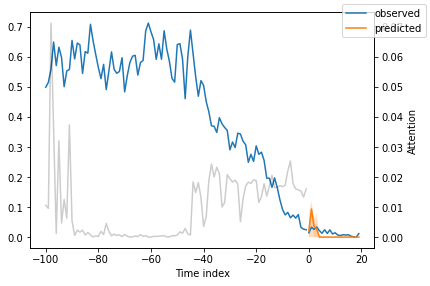

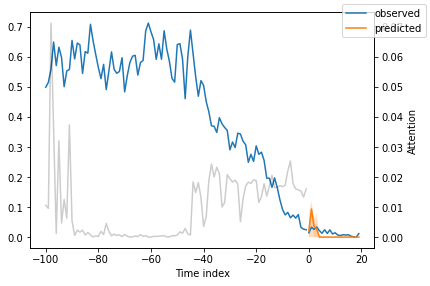

In [ ]:
def plot_prediction(
    self,
    x: Dict[str, torch.Tensor],
    out: Dict[str, torch.Tensor],
    idx: int,
    plot_attention: bool = True,
    add_loss_to_title: bool = False,
    show_future_observed: bool = True,
    ax=None,
) -> plt.Figure:
    """
    Plot actuals vs prediction and attention

    Args:
        x (Dict[str, torch.Tensor]): network input
        out (Dict[str, torch.Tensor]): network output
        idx (int): sample index
        plot_attention: if to plot attention on secondary axis
        add_loss_to_title: if to add loss to title. Default to False.
        show_future_observed: if to show actuals for future. Defaults to True.
        ax: matplotlib axes to plot on

    Returns:
        plt.Figure: matplotlib figure
    """
    # plot prediction as normal
    fig = best_model.plot_prediction(
        x, out, idx=idx, add_loss_to_title=add_loss_to_title, show_future_observed=show_future_observed, ax=ax
    )

    # add attention on secondary axis
    if plot_attention:
        interpretation = self.interpret_output(out)
        ax = fig.axes[0]
        ax2 = ax.twinx()
        ax2.set_ylabel("Attention")
        encoder_length = x["encoder_lengths"][idx]
        ax2.plot(
            torch.arange(-encoder_length, 0),
            interpretation["attention"][idx, :encoder_length].detach().cpu(),
            alpha=0.2,
            color="k",
        )
    fig.tight_layout()
    return fig

raw_predictions, x = best_model.predict(val_dataloader, mode = 'raw', return_x=True)

best_model.plot_prediction( x=x,
    out=raw_predictions,
    idx=0)

{'attention': <Figure size 432x288 with 1 Axes>,
 'decoder_variables': <Figure size 504x198 with 1 Axes>,
 'encoder_variables': <Figure size 504x486 with 1 Axes>,
 'static_variables': <Figure size 504x216 with 1 Axes>}

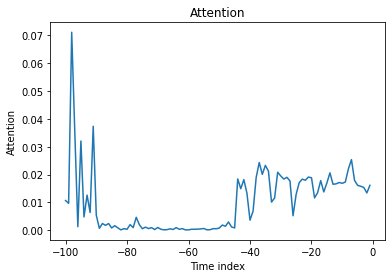

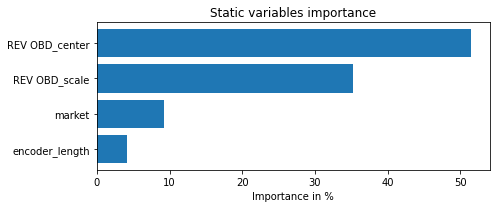

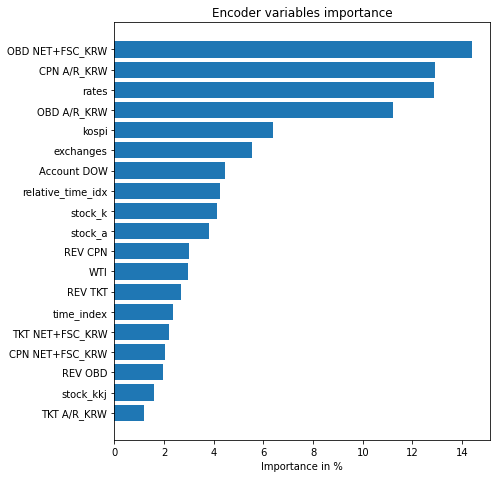

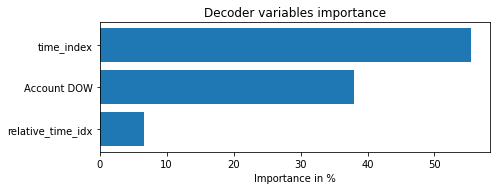

In [ ]:
interpretation = best_model.interpret_output(raw_predictions, reduction="sum")
best_model.plot_interpretation(interpretation)